# yurufuwa_bayesian_deep_learning
ベイズ深層学習をゆるーく試してみるnotebook

(C100新刊対応)

In [1]:
# 標準搭載ライブラリ
import os
import warnings
import random
from IPython.display import Image

# 今回の主題
import tensorflow as tf
import tensorflow_probability as tfp

# データ前処理・後処理用
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.model_selection

# 描画系
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [2]:
print(tf.__version__)
print(tfp.__version__)
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(sns.__version__)

2.8.2
0.16.0
1.21.6
1.3.5
3.2.2
1.0.2
0.11.2


In [3]:
def set_seed(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(seed)

In [4]:
# GPUを使用できているか確認

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6073247408531258307
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12912898367248680193
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# california_housingを用いた回帰タスク

In [35]:
california_housing = sklearn.datasets.fetch_california_housing()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(california_housing.data, california_housing.target)

# NNを安定的に学習させるため、標準化を行う
standard_scaler = sklearn.preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)


## 比較対象として頻度主義的に線形回帰を行う

In [6]:
set_seed(0)

linear_model = tf.keras.models.Sequential([                                
  tf.keras.layers.Dense(1, activation="softplus"),
])


In [7]:

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
)

linear_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
484/484 [==============================] - 5s 3ms/step - loss: 1.4177 - val_loss: 0.6409
Epoch 2/10
484/484 [==============================] - 1s 3ms/step - loss: 0.6913 - val_loss: 0.5283
Epoch 3/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5682 - val_loss: 0.5223
Epoch 4/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5279 - val_loss: 0.5035
Epoch 5/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5261 - val_loss: 0.5071
Epoch 6/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5307 - val_loss: 0.5181
Epoch 7/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5219 - val_loss: 0.5074
Epoch 8/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5346 - val_loss: 0.5061
Epoch 9/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5231 - val_loss: 0.5015
Epoch 10/10
484/484 [==============================] - 1s 3ms/step - loss: 0.5184 - val_loss: 0.4998

In [8]:
pd.DataFrame({"feature": california_housing.feature_names, "weight": linear_model.layers[0].weights[0].numpy().flatten()})

,feature,weight
0,MedInc,0.898599
1,HouseAge,0.154583
2,AveRooms,-0.264401
3,AveBedrms,0.375891
4,Population,-0.039627
5,AveOccup,-0.220622
6,Latitude,-1.376039
7,Longitude,-1.291658


## ベイズ線形回帰

In [36]:
set_seed(0)

kld = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(len(y_train), dtype=tf.float32))

bayesian_linear_model = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=kld,
      activation="softplus"),
])

bayesian_linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error',
)


bayesian_linear_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Epoch 1/10
484/484 [==============================] - 3s 4ms/step - loss: 0.5714 - val_loss: 0.5130
Epoch 2/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5252 - val_loss: 0.4809
Epoch 3/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5172 - val_loss: 0.5800
Epoch 4/10
484/484 [==============================] - 2s 5ms/step - loss: 0.5916 - val_loss: 0.5388
Epoch 5/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5919 - val_loss: 0.8255
Epoch 6/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5856 - val_loss: 0.5159
Epoch 7/10
484/484 [==============================] - 2s 5ms/step - loss: 0.4792 - val_loss: 0.4726
Epoch 8/10
484/484 [==============================] - 2s 4ms/step - loss: 0.4812 - val_loss: 0.4643
Epoch 9/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5113 - val_loss: 0.5242
Epoch 10/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5816 - val_loss: 0.5364

In [37]:
bayesian_linear_model.layers[0].weights

[<tf.Variable 'dense_flipout_10/kernel_posterior_loc:0' shape=(8, 1) dtype=float32, numpy=
 array([[ 0.8862407 ],
        [ 0.14544705],
        [-0.07570529],
        [-0.9290735 ],
        [ 0.14248866],
        [-3.0896766 ],
        [-1.4525656 ],
        [-1.2391114 ]], dtype=float32)>,
 <tf.Variable 'dense_flipout_10/kernel_posterior_untransformed_scale:0' shape=(8, 1) dtype=float32, numpy=
 array([[-4.9417467],
        [-5.5738287],
        [-4.581266 ],
        [-6.12328  ],
        [-4.9619565],
        [-3.813516 ],
        [-5.6683016],
        [-5.963254 ]], dtype=float32)>,
 <tf.Variable 'dense_flipout_10/bias_posterior_loc:0' shape=(1,) dtype=float32, numpy=array([1.73708], dtype=float32)>]

In [38]:

pd.DataFrame({
    "feature": california_housing.feature_names, 
    "weight_loc": bayesian_linear_model.layers[0].weights[0].numpy().flatten(),
    "weight_scale": tf.nn.softplus(bayesian_linear_model.layers[0].weights[1]).numpy().flatten(),
})

,feature,weight_loc,weight_scale
0,MedInc,0.886241,0.007117
1,HouseAge,0.145447,0.003789
2,AveRooms,-0.075705,0.010190
3,AveBedrms,-0.929074,0.002189
4,Population,0.142489,0.006975
5,AveOccup,-3.089677,0.021830
6,Latitude,-1.452566,0.003448
7,Longitude,-1.239111,0.002568


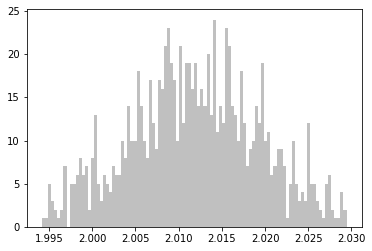

In [39]:

preds = bayesian_linear_model.predict(np.stack([X_test[0] for _ in range(1000)])).flatten()
preds_mean = preds.mean()
preds_std = preds.std()

plt.hist(preds, bins=100, range=(preds.mean() - 2 * preds_std, preds.mean() + 2* preds_std), color="silver")
plt.show()

### 事前分布とのKLダイバージェンスを損失からなくして純粋な最尤法にすると、標準偏差は0に収束する

In [13]:
set_seed(0)

bayesian_linear_model_wo_kld = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=(lambda q,p,_: 0),
      activation="softplus"),
])

bayesian_linear_model_wo_kld.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error',
)

bayesian_linear_model_wo_kld.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

pd.DataFrame({
    "feature": california_housing.feature_names, 
    "weight_loc": bayesian_linear_model_wo_kld.layers[0].weights[0].numpy().flatten(),
    "weight_scale": tf.nn.softplus(bayesian_linear_model_wo_kld.layers[0].weights[1]).numpy().flatten(),
})

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


484/484 [==============================] - 2s 4ms/step - loss: 0.6308 - val_loss: 0.5352
Epoch 2/10
484/484 [==============================] - 2s 3ms/step - loss: 0.4893 - val_loss: 0.4738
Epoch 3/10
484/484 [==============================] - 2s 3ms/step - loss: 0.5316 - val_loss: 0.5848
Epoch 4/10
484/484 [==============================] - 2s 3ms/step - loss: 0.5072 - val_loss: 0.4801
Epoch 5/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5653 - val_loss: 0.4699
Epoch 6/10
484/484 [==============================] - 2s 4ms/step - loss: 0.5814 - val_loss: 0.6411
Epoch 7/10
484/484 [==============================] - 2s 3ms/step - loss: 0.5399 - val_loss: 0.5178
Epoch 8/10
484/484 [==============================] - 2s 3ms/step - loss: 0.5442 - val_loss: 0.4771
Epoch 9/10
484/484 [==============================] - 2s 3ms/step - loss: 0.4770 - val_loss: 0.5093
Epoch 10/10
484/484 [==============================] - 2s 4ms/step - loss: 0.8440 - val_loss: 0.5391


,feature,weight_loc,weight_scale
0,MedInc,0.751961,0.001056
1,HouseAge,0.096465,0.000249
2,AveRooms,-0.126772,0.000427
3,AveBedrms,-1.122054,0.000069
4,Population,-0.017448,0.001059
5,AveOccup,-6.338371,0.003092
6,Latitude,-1.464091,0.000384
7,Longitude,-1.388277,0.000452


In [14]:
set_seed(0)

bayesian_linear_model_wo_kld = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=(lambda q,p,_: 0),
      activation="softplus"),
])

bayesian_linear_model_wo_kld.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error',
)

bayesian_linear_model_wo_kld.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

pd.DataFrame({
    "feature": california_housing.feature_names, 
    "weight_loc": bayesian_linear_model_wo_kld.layers[0].weights[0].numpy().flatten(),
    "weight_scale": tf.nn.softplus(bayesian_linear_model_wo_kld.layers[0].weights[1]).numpy().flatten(),
})

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


484/484 [==============================] - 5s 7ms/step - loss: 0.6308 - val_loss: 0.5352
Epoch 2/50
484/484 [==============================] - 3s 7ms/step - loss: 0.4893 - val_loss: 0.4738
Epoch 3/50
484/484 [==============================] - 3s 7ms/step - loss: 0.5316 - val_loss: 0.5848
Epoch 4/50
484/484 [==============================] - 3s 6ms/step - loss: 0.5072 - val_loss: 0.4801
Epoch 5/50
484/484 [==============================] - 3s 6ms/step - loss: 0.5653 - val_loss: 0.4699
Epoch 6/50
484/484 [==============================] - 2s 4ms/step - loss: 0.5814 - val_loss: 0.6411
Epoch 7/50
484/484 [==============================] - 2s 4ms/step - loss: 0.5399 - val_loss: 0.5178
Epoch 8/50
484/484 [==============================] - 2s 3ms/step - loss: 0.5442 - val_loss: 0.4771
Epoch 9/50
484/484 [==============================] - 2s 4ms/step - loss: 0.4770 - val_loss: 0.5093
Epoch 10/50
484/484 [==============================] - 2s 4ms/step - loss: 0.8440 - val_loss: 0.5391
Epoch 11/5

,feature,weight_loc,weight_scale
0,MedInc,0.906435,1.728074e-06
1,HouseAge,0.136668,1.507539e-06
2,AveRooms,-0.295302,2.413124e-03
3,AveBedrms,0.193580,6.907033e-07
4,Population,0.004186,6.301455e-07
5,AveOccup,-5.476176,4.903051e-05
6,Latitude,-1.460172,2.729194e-05
7,Longitude,-1.381615,9.952395e-07


## ベイズ深層学習

In [42]:
set_seed(0)

kld = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(len(y_train), dtype=tf.float32))

bayesian_deep_model = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      8, kernel_divergence_fn=kld,
      activation="sigmoid"),
  tfp.layers.DenseFlipout(
      8, kernel_divergence_fn=kld,
      activation="sigmoid"),
  tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=kld,
      activation="softplus"),
])

bayesian_deep_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error',
)

bayesian_deep_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
484/484 [==============================] - 5s 7ms/step - loss: 0.7406 - val_loss: 0.4297
Epoch 2/10
484/484 [==============================] - 3s 6ms/step - loss: 0.4160 - val_loss: 0.4292
Epoch 3/10
484/484 [==============================] - 3s 6ms/step - loss: 0.4057 - val_loss: 0.4134
Epoch 4/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3998 - val_loss: 0.4089
Epoch 5/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3960 - val_loss: 0.4057
Epoch 6/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3964 - val_loss: 0.4000
Epoch 7/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3935 - val_loss: 0.4000
Epoch 8/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3907 - val_loss: 0.4002
Epoch 9/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3881 - val_loss: 0.4384
Epoch 10/10
484/484 [==============================] - 3s 6ms/step - loss: 0.3893 - val_loss: 0.3990

In [48]:

pd.DataFrame({
    "weight_loc": bayesian_deep_model.layers[-1].weights[0].numpy().flatten(),
    "weight_scale": tf.nn.softplus(bayesian_deep_model.layers[-1].weights[1]).numpy().flatten(),
})


,weight_loc,weight_scale
0,1.056203,0.012558
1,0.851890,0.014452
2,0.812811,0.022366
3,0.632123,0.015507
4,0.479700,0.015547
5,-0.938994,0.028776
6,0.816286,0.012774
7,0.759420,0.014351


In [44]:
df_test = pd.DataFrame(X_test, columns=california_housing.feature_names)

preds = tf.stack([bayesian_deep_model.predict(df_test) for _ in range(100)])
df_test["BayesPred"] = tf.keras.backend.mean(preds,axis=0).numpy().flatten()
df_test["BayesPredStd"] = tf.keras.backend.std(preds,axis=0).numpy().flatten()

# ベイズ予測分布の分散が大きいデータ群
df_test.sort_values("BayesPredStd", ascending=False).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,BayesPred,BayesPredStd
531,0.577446,-0.997332,19.155083,17.494595,-1.192990,-0.174874,1.572459,-0.288638,2.326767,0.393221
4341,-0.206526,-0.917891,4.466559,10.434643,-1.195591,-0.084811,1.072266,0.005928,1.943528,0.373404
563,2.177456,-1.553415,0.861136,-0.112814,9.921736,0.053164,-0.694772,0.400347,3.781039,0.230090
2026,-0.879344,-0.441249,0.878770,3.863893,-0.932008,-0.122697,-0.671398,1.678463,2.113593,0.229555
2507,5.856105,0.512037,1.182102,-0.059187,-1.007441,1.189081,-0.708796,0.769802,3.525534,0.225943


In [45]:
# ベイズ予測分布の分散が小さいデータ群
df_test.sort_values("BayesPredStd", ascending=True).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,BayesPred,BayesPredStd
3582,0.203020,1.385882,1.367065,0.402081,4.423766,95.087403,-0.152506,-0.558240,1.255389,0.010924
3494,-0.913517,-0.679570,0.115304,0.043333,-0.077095,0.189538,0.104602,0.140730,1.051510,0.015943
2809,-0.757449,-1.394534,-0.469515,0.378711,-0.046749,0.253500,0.300940,-0.343557,1.332692,0.016140
1099,-0.462479,-1.871177,0.013072,-0.125543,0.307875,0.121833,0.202771,0.255560,1.213193,0.016279
2073,-0.265025,-1.553415,-0.854954,-0.122180,-0.149928,0.880060,-0.891109,0.859670,1.261405,0.016836


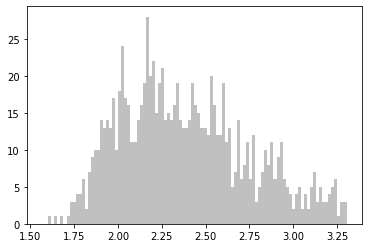

In [46]:

preds = bayesian_deep_model.predict(pd.DataFrame([df_test[california_housing.feature_names].iloc[df_test["BayesPredStd"].idxmax()]]*1000)).flatten()
preds_mean = preds.mean()
preds_std = preds.std()

plt.hist(preds, bins=100, range=(preds.mean() - 2 * preds_std, preds.mean() + 2* preds_std), color="silver")
plt.show()

# mnist

参考: https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/bayesian_neural_network.py

## 可視化部分
- 重要ではないのと参考ソースをほぼ丸々流用しているので、本編では触れない

In [20]:

matplotlib.use('Agg')
warnings.simplefilter(action='ignore')

def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
  
  fig = matplotlib.figure.Figure(figsize=(6, 3))
  canvas = matplotlib.backends.backend_agg.FigureCanvasAgg(fig)

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(qm.reshape([-1]), ax=ax, label=n)
  ax.set_title('weight means')
  ax.set_xlim([-1.5, 1.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(qs.reshape([-1]), ax=ax)
  ax.set_title('weight stddevs')
  ax.set_xlim([0, 1.])

  fig.tight_layout()
  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))


def plot_heldout_prediction(input_vals, probs, fname, n=10, title=''):
  
  fig = matplotlib.figure.Figure(figsize=(9, 3*n))
  canvas = matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(input_vals.shape[1:]), interpolation='None')

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title('posterior samples')

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), np.mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('predictive probs')
  fig.suptitle(title)
  fig.tight_layout()

  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))



In [21]:
def create_model(num_train_examples: int, num_classes: int):


  kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / 
                            tf.cast(num_train_examples, dtype=tf.float32))

  model = tf.keras.models.Sequential([
      tfp.layers.Convolution2DFlipout(
          6, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          16, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          120, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseFlipout(
          84, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tfp.layers.DenseFlipout(
          num_classes, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(lr=0.001)
  
  model.compile(optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'], experimental_run_tf_function=False)
  return model



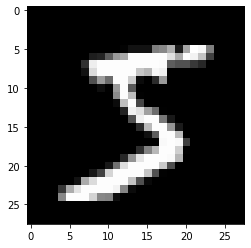

In [51]:
train_set, test_set = tf.keras.datasets.mnist.load_data()

# MinMaxScalingを行う
def normalize_image(images):
  return (2*(images / 255.) - 1)

X_train, y_train = normalize_image(train_set[0]), tf.keras.utils.to_categorical(train_set[1])
X_test, y_test = normalize_image(test_set[0]), tf.keras.utils.to_categorical(test_set[1])

pixels = X_train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

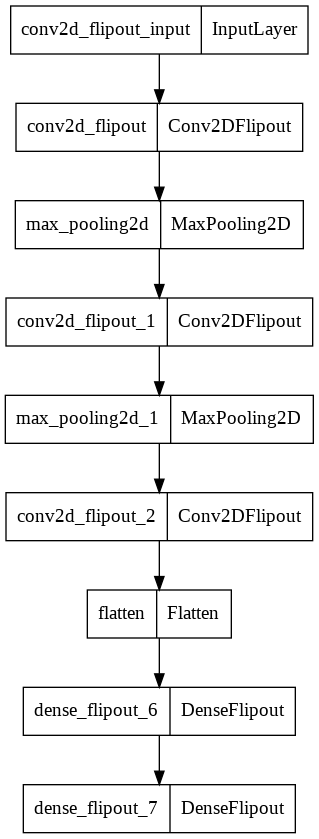

In [23]:
set_seed(0)

bayesian_cnn_model = create_model(X_train.shape[0], y_train.shape[1])

bayesian_cnn_model.build(input_shape=[None, 28, 28, 1])

tf.keras.utils.plot_model(bayesian_cnn_model)

In [24]:
bayesian_cnn_model.fit(
    x=X_train, 
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size = 128,
    epochs=10
)

Epoch 1/10
469/469 [==============================] - 22s 20ms/step - loss: 22.8869 - accuracy: 0.7460 - val_loss: 21.2591 - val_accuracy: 0.9443
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 20.1210 - accuracy: 0.9524 - val_loss: 18.9499 - val_accuracy: 0.9640
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 17.8017 - accuracy: 0.9682 - val_loss: 16.6364 - val_accuracy: 0.9729
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 15.5139 - accuracy: 0.9742 - val_loss: 14.4011 - val_accuracy: 0.9749
Epoch 5/10
469/469 [==============================] - 5s 11ms/step - loss: 13.3463 - accuracy: 0.9770 - val_loss: 12.3162 - val_accuracy: 0.9786
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 11.3688 - accuracy: 0.9796 - val_loss: 10.4606 - val_accuracy: 0.9780
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 9.6354 - accuracy: 0.9794 - val_loss: 8.8597 - val_acc

In [25]:
names = [layer.name for layer in bayesian_cnn_model.layers
          if 'flipout' in layer.name]

qm_vals = [layer.kernel_posterior.mean().numpy()
            for layer in bayesian_cnn_model.layers
            if 'flipout' in layer.name]

qs_vals = [layer.kernel_posterior.stddev().numpy()
            for layer in bayesian_cnn_model.layers
            if 'flipout' in layer.name]

probs = tf.stack([bayesian_cnn_model.predict(X_test[:10], verbose=1)
                  for _ in range(100)], axis=0)

fig_dir="/tmp/bayesian_neural_network/"
os.makedirs(fig_dir,exist_ok=True)

plot_weight_posteriors(names, qm_vals, qs_vals, f"{fig_dir}/weight.png",)
plot_heldout_prediction(X_test[:10], probs.numpy(), f"{fig_dir}/probabilty.png",)

1/1 [==============================] - 0s 25ms/step
saved /tmp/bayesian_neural_network//weight.png
saved /tmp/bayesian_neural_network//probabilty.png


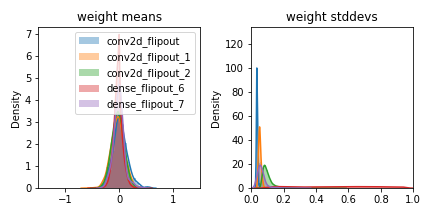

In [26]:

Image(filename=f'{fig_dir}/weight.png') 

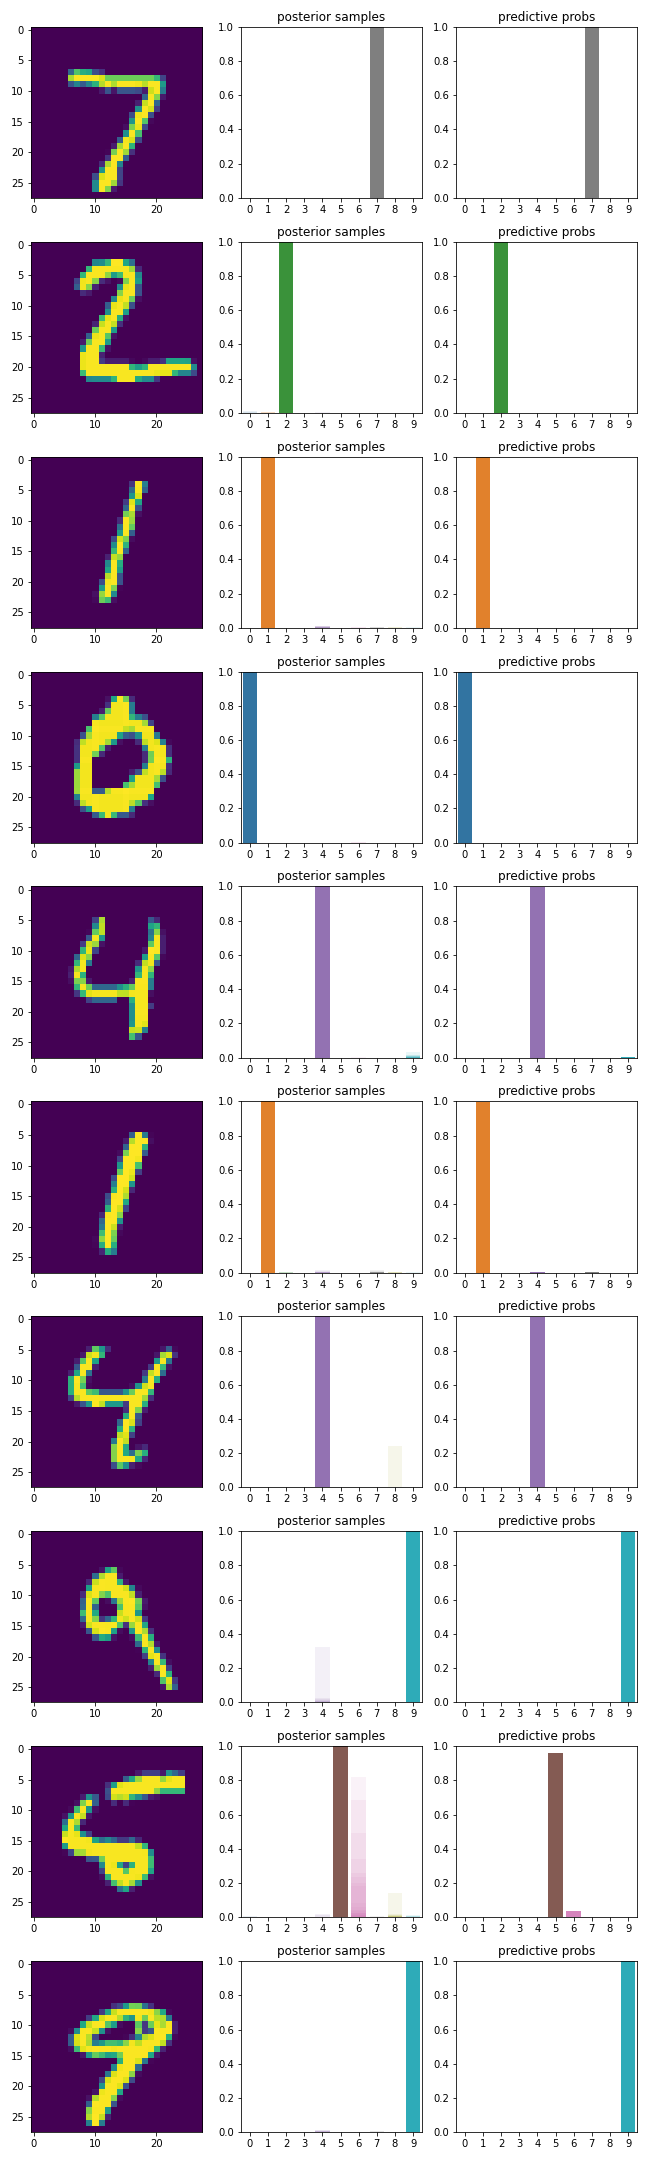

In [27]:
Image(filename=f'{fig_dir}/probabilty.png') 